<a href="https://colab.research.google.com/github/sekhar0146/ML_regression_projects/blob/main/bike_sharing_demand_prediction_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# Import numpy
import numpy as np
# Import pandas
import pandas as pd
# Import Ridge from sklearn's GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
# Import Ridge from sklearn's RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
# Import Ridge from sklearn's linear_model module
from sklearn.linear_model import Ridge
# Import SVR from sklearn's svm module
from sklearn.svm import SVR
# Import XGBoost regressor
from xgboost import XGBRegressor
# Import lasso regressior
from sklearn.linear_model import Lasso

In [28]:
# import the data
df = pd.read_csv("drive/My Drive/bike-sharing-demand/train.csv",
                 low_memory=False,
                 parse_dates=["datetime"]) # convert into yyyy-mm-dd

df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
# Check for null
df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [ ]:
# check for non_numeric data if available 
df.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

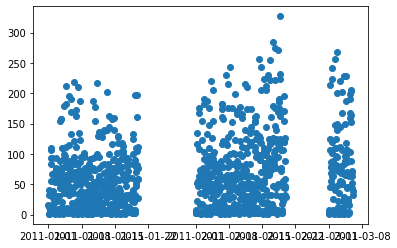

In [4]:
import matplotlib.pyplot as plt
# plot the data between datetime and count
fig1, ax1 = plt.subplots()
ax1.scatter(df["datetime"][:1000], df["count"][:1000]);

In [29]:
# Sort the DataFrame by datetime
# when working with time series, it is good to sort it by date
df.sort_values(by=["datetime"], 
               inplace=True,
               ascending=True)
print(df.datetime[:5])


0   2011-01-01 00:00:00
1   2011-01-01 01:00:00
2   2011-01-01 02:00:00
3   2011-01-01 03:00:00
4   2011-01-01 04:00:00
Name: datetime, dtype: datetime64[ns]


In [30]:
# Make a copy of original dataframe - for future reference
df_tmp = df.copy()

In [31]:
# datetime is non-numeric so, we need to turn that into numeric
# We can convert that into day, month, year , etc...
# import the data again with parse dates
df_tmp["year"] = df_tmp.datetime.dt.year
df_tmp["month"] = df_tmp.datetime.dt.month
df_tmp["day"] = df_tmp.datetime.dt.day
df_tmp["hour"] = df_tmp.datetime.dt.hour
df_tmp.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [32]:
# Now we have enrichied our dataframe with year, month and day features,
# we can remove datetime
df_tmp.drop("datetime", axis=1, inplace=True)
df_tmp.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [33]:
# I feel casual and registered coloumns are not needed for our predictions as both results count column 
df_tmp.drop(["casual","registered"], axis=1, inplace=True)
df_tmp.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4


In [ ]:
### Exploratory data analysis

In [168]:
import seaborn as sns
import matplotlib.pyplot as plt

<Figure size 1080x432 with 0 Axes>

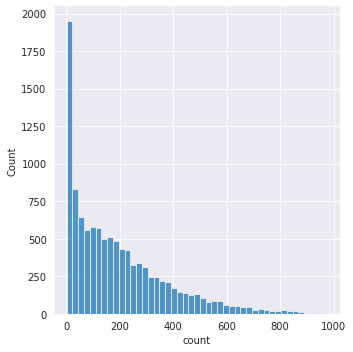

In [179]:
sns.set_style("darkgrid")
plt.figure(figsize=(15,6))
sns.displot(df_tmp, x="count");

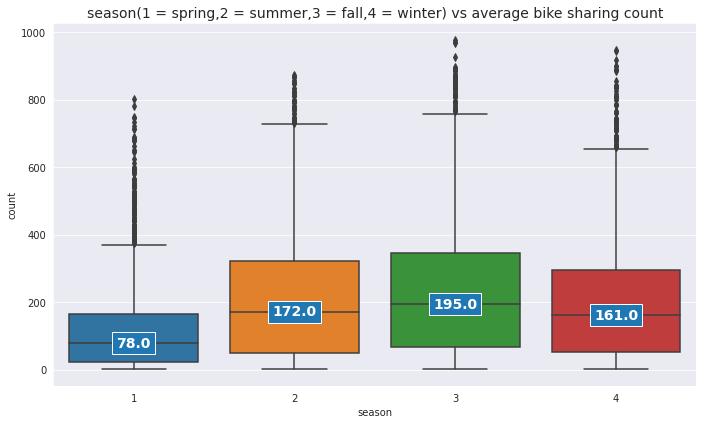

In [187]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,6))
box_plot = sns.boxplot(x='season', y='count', data=df_tmp)

# Diaplay mean data labels in boxplot
ax = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()
ax.set_title("season(1 = spring,2 = summer,3 = fall,4 = winter) vs average bike sharing count", size="14")

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],1) 

    ax.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=14,
        color='white',
        bbox=dict())

box_plot.figure.tight_layout()

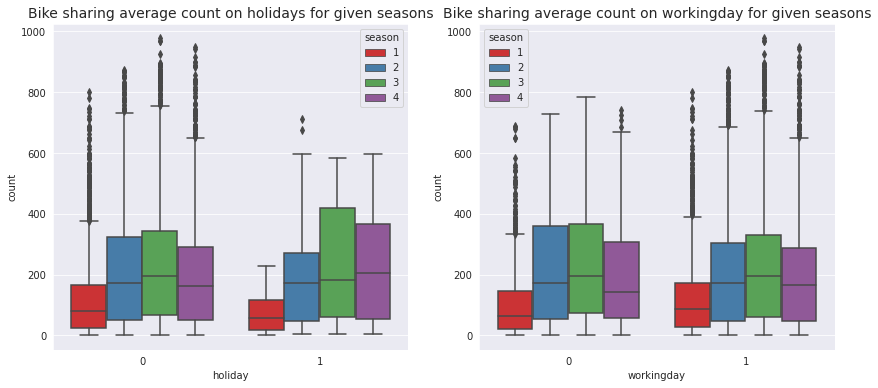

In [194]:
sns.set_style("darkgrid") 
plt.figure(figsize=(14,6))

#==> Bike sharing average count on holidays for given seasons
plt.subplot(1,2,1)
box_plot = sns.boxplot(x='holiday', y='count', hue='season', data=df_tmp, palette='Set1')

# Diaplay mean data labels in boxplot
ax = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()
ax.set_title("Bike sharing average count on holidays for given seasons", size="14")

#==> Bike sharing average count on workingday for given seasons
plt.subplot(1,2,2)
box_plot = sns.boxplot(x='workingday', y='count', hue='season', data=df_tmp, palette='Set1')

# Diaplay mean data labels in boxplot
ax = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()
ax.set_title("Bike sharing average count on workingday for given seasons", size="14");

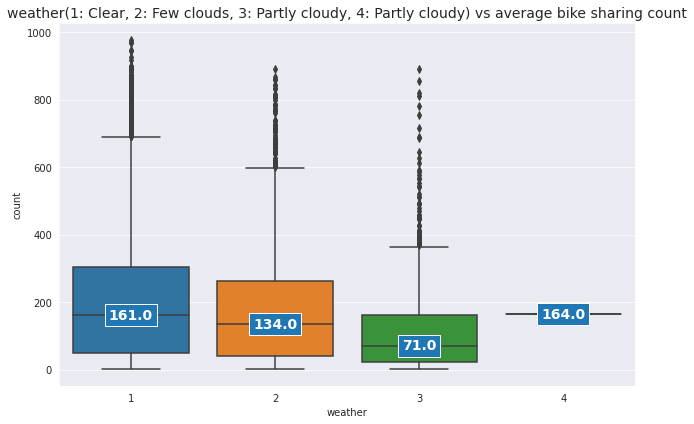

In [196]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,6))
box_plot = sns.boxplot(x='weather', y='count', data=df_tmp)

# Diaplay mean data labels in boxplot
ax = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()
ax.set_title("weather(1: Clear, 2: Few clouds, 3: Partly cloudy, 4: Partly cloudy) vs average bike sharing count", size="14")

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],1) 

    ax.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=14,
        color='white',
        bbox=dict())

box_plot.figure.tight_layout()

In [197]:
df_tmp

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0000,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0000,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0000,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0000,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0000,1,2011,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,336,2012,12,19,19
10882,4,0,1,1,14.76,17.425,57,15.0013,241,2012,12,19,20
10883,4,0,1,1,13.94,15.910,61,15.0013,168,2012,12,19,21
10884,4,0,1,1,13.94,17.425,61,6.0032,129,2012,12,19,22


In [ ]:
df_tmp.weather.unique()

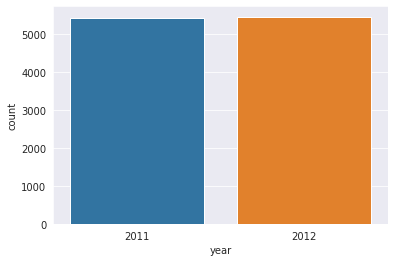

In [200]:
sns.countplot(x='year', data=df_tmp);

In [ ]:
### Model processing 

In [34]:
# split dataset
from sklearn.model_selection import train_test_split

X = df_tmp.drop("count", axis=1)
y = df_tmp["count"]   # count is the target variable 

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8708, 12), (2178, 12), (8708,), (2178,))

In [12]:
# ===========================================
# Modele processing 
# ===========================================
models={"GradientBoostingRegressor": GradientBoostingRegressor(),
        "RandomForestRegressor": RandomForestRegressor(),
        "Ridge": Ridge(),
        "SVR_linear": SVR(kernel="linear"),
        "SVR_rbf": SVR(kernel="rbf"),
        "XGBRegressor" : XGBRegressor(),
        "Lasso" : Lasso()
        }

reg_result={}

np.random.seed(42)

for model_name, model in models.items():
  model.fit(X_train, y_train)
  reg_result[model_name] = model.score(X_test, y_test)

reg_result

[07:14:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'GradientBoostingRegressor': 0.8552462637527738,
 'Lasso': 0.3764844721108004,
 'RandomForestRegressor': 0.9363361800702621,
 'Ridge': 0.3777148967106291,
 'SVR_linear': 0.3074241840563966,
 'SVR_rbf': -0.0823325067098728,
 'XGBRegressor': 0.8555119045668896}

                           model_score
model                                 
SVR_rbf                      -0.082333
SVR_linear                    0.307424
Lasso                         0.376484
Ridge                         0.377715
GradientBoostingRegressor     0.855246
XGBRegressor                  0.855512
RandomForestRegressor         0.936336


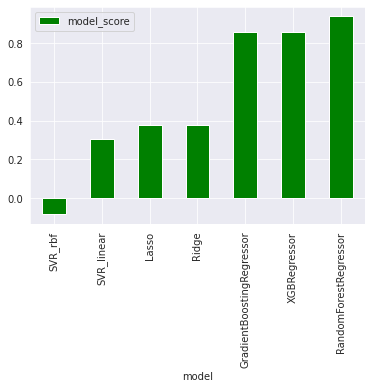

In [201]:
# Visualize model scores in bar chart 
df_reg = pd.DataFrame(reg_result.items(), columns=['model', 'model_score'])
df_reg = df_reg.set_index('model')
df_reg.sort_values(by=['model_score'], inplace=True)
print(df_reg)
df_reg.plot(kind='bar', color='green');

In [14]:
# ------------------------------------------------------------
# Hyperparameter tuning with RandomizedSearchCV
# ------------------------------------------------------------
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report

print("=== Hyperparameter tuning with RandomizedSearchCV ===")

# different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(200, 2000, 10),
           "max_depth": [None, 3 , 5, 10, 20, 30],
           "min_samples_split":np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"]
           }

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              n_iter=2,
                              cv=5,
                              verbose=True)
rs_model.fit(X_train, y_train)
print("Hyperparameter best parameters")
print(rs_model.best_params_)
print("RandomForestRegressor score: ", rs_model.score(X_train, y_train))
print("")   

=== Hyperparameter tuning with RandomizedSearchCV ===
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   42.0s finished


Hyperparameter best parameters
{'n_estimators': 760, 'min_samples_split': 8, 'min_samples_leaf': 11, 'max_features': 'auto', 'max_depth': 3}
RandomForestRegressor score:  0.5358441477376736



In [67]:
# Lets manually tune the hyper parameters: RandomForestRegressor
# Manually changing the hyperparameters until get a better score than earlier 
rf1 = RandomForestRegressor(n_estimators=90,
                            max_depth=30,
                            min_samples_split=2,
                            random_state=10)
rf1.fit(X_train, y_train)
rf1.score(X_test, y_test)

0.9531200105000981

In [82]:
# Lets manually tune the hyper parameters: GradientBoostingRegressor
# Manually changing the hyperparameters until get a better score than earlier 
gb1 = GradientBoostingRegressor(n_estimators=70,
                            max_depth=8,
                            learning_rate=0.1,
                            random_state=10)
gb1.fit(X_train, y_train)
gb1.score(X_test, y_test)

0.958522925025014

In [126]:
# Lets manually tune the hyper parameters: XGBRegressor
# Manually changing the hyperparameters until get a better score than earlier 
xb1 = XGBRegressor(n_estimators=140,
                   max_depth=8,
                   learning_rate=0.1,
                   random_state=10)
xb1.fit(X_train, y_train)
xb1.score(X_test, y_test)

[08:22:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9618454480330046

In [ ]:
# After tunning RandomForestRegressor(), GradientBoostingRegressor() and XGBRegressor()
# we undesrtand that XGBRegressor is giving better score 
# Lets use xb1 model (XGBRegressor) for our prediction

In [139]:
# -----------------------------------
# calculate RMSLE
# -----------------------------------
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_pred):
    """
    calculates room mean squared log error b/w true and prediction values
    """
    return np.sqrt(mean_squared_log_error(y_test, y_pred))

def show_score(model):
    y_preds = model.predict(X_test)
    scores = {"MAE": mean_absolute_error(y_test, y_preds),
              #"RMSLE" : rmsle(y_test, y_preds),
              "R^2": r2_score(y_test, y_preds)
              }
    return scores

In [140]:
show_score(xb1)   # Passing tunned model XGBRegressor to evaluate the metrics

{'MAE': 24.276939740673022, 'R^2': 0.9618454480330046}

In [141]:
# import the test dataset
df_test = pd.read_csv("drive/My Drive/bike-sharing-demand/test.csv",
                 low_memory=False,
                 parse_dates=["datetime"]) # convert into yyyy-mm-dd
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [142]:
# backup of df_test
df_test_bck = df_test.copy()
df_test_bck.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [143]:
# datetime is non-numeric so, we need to turn that into numeric
# We can convert that into day, month, year , etc...
# import the data again with parse dates
df_test["year"] = df_test.datetime.dt.year
df_test["month"] = df_test.datetime.dt.month
df_test["day"] = df_test.datetime.dt.day
df_test["hour"] = df_test.datetime.dt.hour
df_test.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,2012,12,31,19
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,2012,12,31,20
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,2012,12,31,21
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,2012,12,31,22
6492,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981,2012,12,31,23


In [144]:
# Now we have enrichied our test dataframe with year, month, day and hour features,
# we can remove datetime
df_test.drop("datetime", axis=1, inplace=True)
df_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1
2,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2
3,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3
4,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4


In [ ]:
df_test.shape

(6493, 12)

In [ ]:
# check for missing values
df_test.isna().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
year          0
month         0
day           0
hour          0
dtype: int64

In [ ]:
# Check for non-numeric data
df_test.dtypes

season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
year            int64
month           int64
day             int64
hour            int64
dtype: object

In [145]:
# Find the column differences b/w training and test data sets
print(set(X_train.columns) - set(df_test.columns))
print(set(df_test.columns) - set(X_train.columns))

set()
set()


In [147]:
# Now we have same columns at df_test and X_train. Lets do prediction
print("========= Predicted count ============ ")
test_preds = xb1.predict(df_test)
test_preds

========= Predicted count ============ 


array([ 10.831863 ,   3.8284507,   2.478871 , ..., 131.74918  ,
       113.194565 ,  59.51968  ], dtype=float32)

In [148]:
# Now we will add predicted data to test set and save it in DF
df_test["pridicted_count"] = test_preds
df_test


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,pridicted_count
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,10.831863
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,3.828451
2,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,2.478871
3,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,4.530876
4,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,4.530876
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,1,0,1,2,10.66,12.880,60,11.0014,2012,12,31,19,238.773880
6489,1,0,1,2,10.66,12.880,60,11.0014,2012,12,31,20,174.469452
6490,1,0,1,1,10.66,12.880,60,11.0014,2012,12,31,21,131.749176
6491,1,0,1,1,10.66,13.635,56,8.9981,2012,12,31,22,113.194565


In [149]:
df_bike_sharing_preds = pd.DataFrame()
df_bike_sharing_preds["datetime"] = df_test_bck["datetime"]
df_bike_sharing_preds["count_preds"] = test_preds
df_bike_sharing_preds.head(10)

,datetime,count_preds
0,2011-01-20 00:00:00,10.831863
1,2011-01-20 01:00:00,3.828451
2,2011-01-20 02:00:00,2.478871
3,2011-01-20 03:00:00,4.530876
4,2011-01-20 04:00:00,4.530876
5,2011-01-20 05:00:00,11.262241
6,2011-01-20 06:00:00,36.751785
7,2011-01-20 07:00:00,90.644386
8,2011-01-20 08:00:00,226.745193
9,2011-01-20 09:00:00,121.895332
